In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
from scipy import stats
import joblib
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_recall_curve, precision_recall_fscore_support, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV, GroupKFold, StratifiedGroupKFold, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
from sklearn import set_config
import lightgbm as lgbm
import statsmodels.api as sm
from typing import Dict, List
import os

set_config(display="diagram")
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)
sns.set_style(style="darkgrid")
%matplotlib inline

In [4]:
df: DataFrame = pd.read_csv(filepath_or_buffer=r"D:\Python\data analysis projects\diabetes\diabetes.csv")
print(df.shape)

df.sample(frac=0.1)

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
368,3,81,86,16,66,27.5,0.306,22,0
696,3,169,74,19,125,29.9,0.268,31,1
323,13,152,90,33,29,26.8,0.731,43,1
510,12,84,72,31,0,29.7,0.297,46,1
10,4,110,92,0,0,37.6,0.191,30,0
...,...,...,...,...,...,...,...,...,...
8,2,197,70,45,543,30.5,0.158,53,1
628,5,128,80,0,0,34.6,0.144,45,0
732,2,174,88,37,120,44.5,0.646,24,1
309,2,124,68,28,205,32.9,0.875,30,1


## Missing Data
**No Missing Data and Very small data set**

In [5]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [6]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
px.box(data_frame=df, orientation="h")

## testing the accuracy of KNN Imputer and sample imputer(strategy=mean)
**by using evaluation metrics**

- accuracy, precision, recall, F1-score

Text(0.5, 1.0, 'KNN imputer confusion matrix')

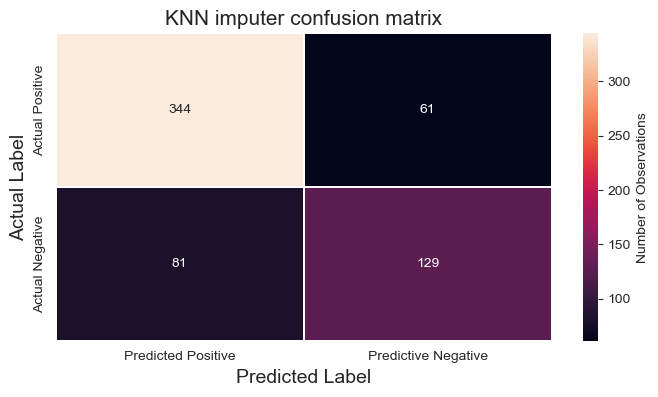

In [8]:
df_cleaning = df.copy()

Y = df_cleaning[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]]

Y.replace(to_replace=0, value=np.nan,inplace=True)

k = np.int64(np.ceil(np.sqrt(df.shape[0])))

impute =KNNImputer(n_neighbors=k if k % 2 != 0 else k - 1, weights="uniform", metric="nan_euclidean", missing_values=np.nan)
imputed_data = impute.fit_transform(X=Y)
# Convert the result back to a DataFrame if necessary
df_cleaning[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]] = np.round(a=imputed_data, decimals=2)
df_cleaning

X_train, X_test, Y_train, y_test = train_test_split(df_cleaning.iloc[:,:-1], df_cleaning.iloc[:,-1],train_size=0.2, random_state=42)

logistic = LogisticRegression()

fitted_logistic: LogisticRegression = logistic.fit(X=X_train, y=Y_train)
y_predict: np.ndarray = fitted_logistic.predict(X=X_test)

accuracy_knn: float = accuracy_score(y_true=y_test, y_pred=y_predict)
precision_knn: float  = precision_score(y_true=y_test, y_pred=y_predict)
recall_knn: float  = recall_score(y_true=y_test, y_pred=y_predict)
f1_knn: float  = f1_score(y_true=y_test, y_pred=y_predict)


cm: np.ndarray = confusion_matrix(y_true=y_test, y_pred=y_predict)
plt.figure(figsize=(8,4))
sns.heatmap(
    data=cm,
    xticklabels=["Predicted Positive", "Predictive Negative"],
    yticklabels=["Actual Positive", "Actual Negative"],
    cbar_kws={'label': 'Number of Observations'},
    linewidths=0.2, 
    fmt="d",
    annot=True,
)

plt.xlabel(xlabel="predicted label".title(), fontsize=14)
plt.ylabel(ylabel="actual label".title(), fontsize=14)
plt.title(label="KNN imputer confusion matrix", fontsize=15)

Accuracy: 0.7610
Precision: 0.6615
Recall: 0.6143
F1 Score: 0.6370


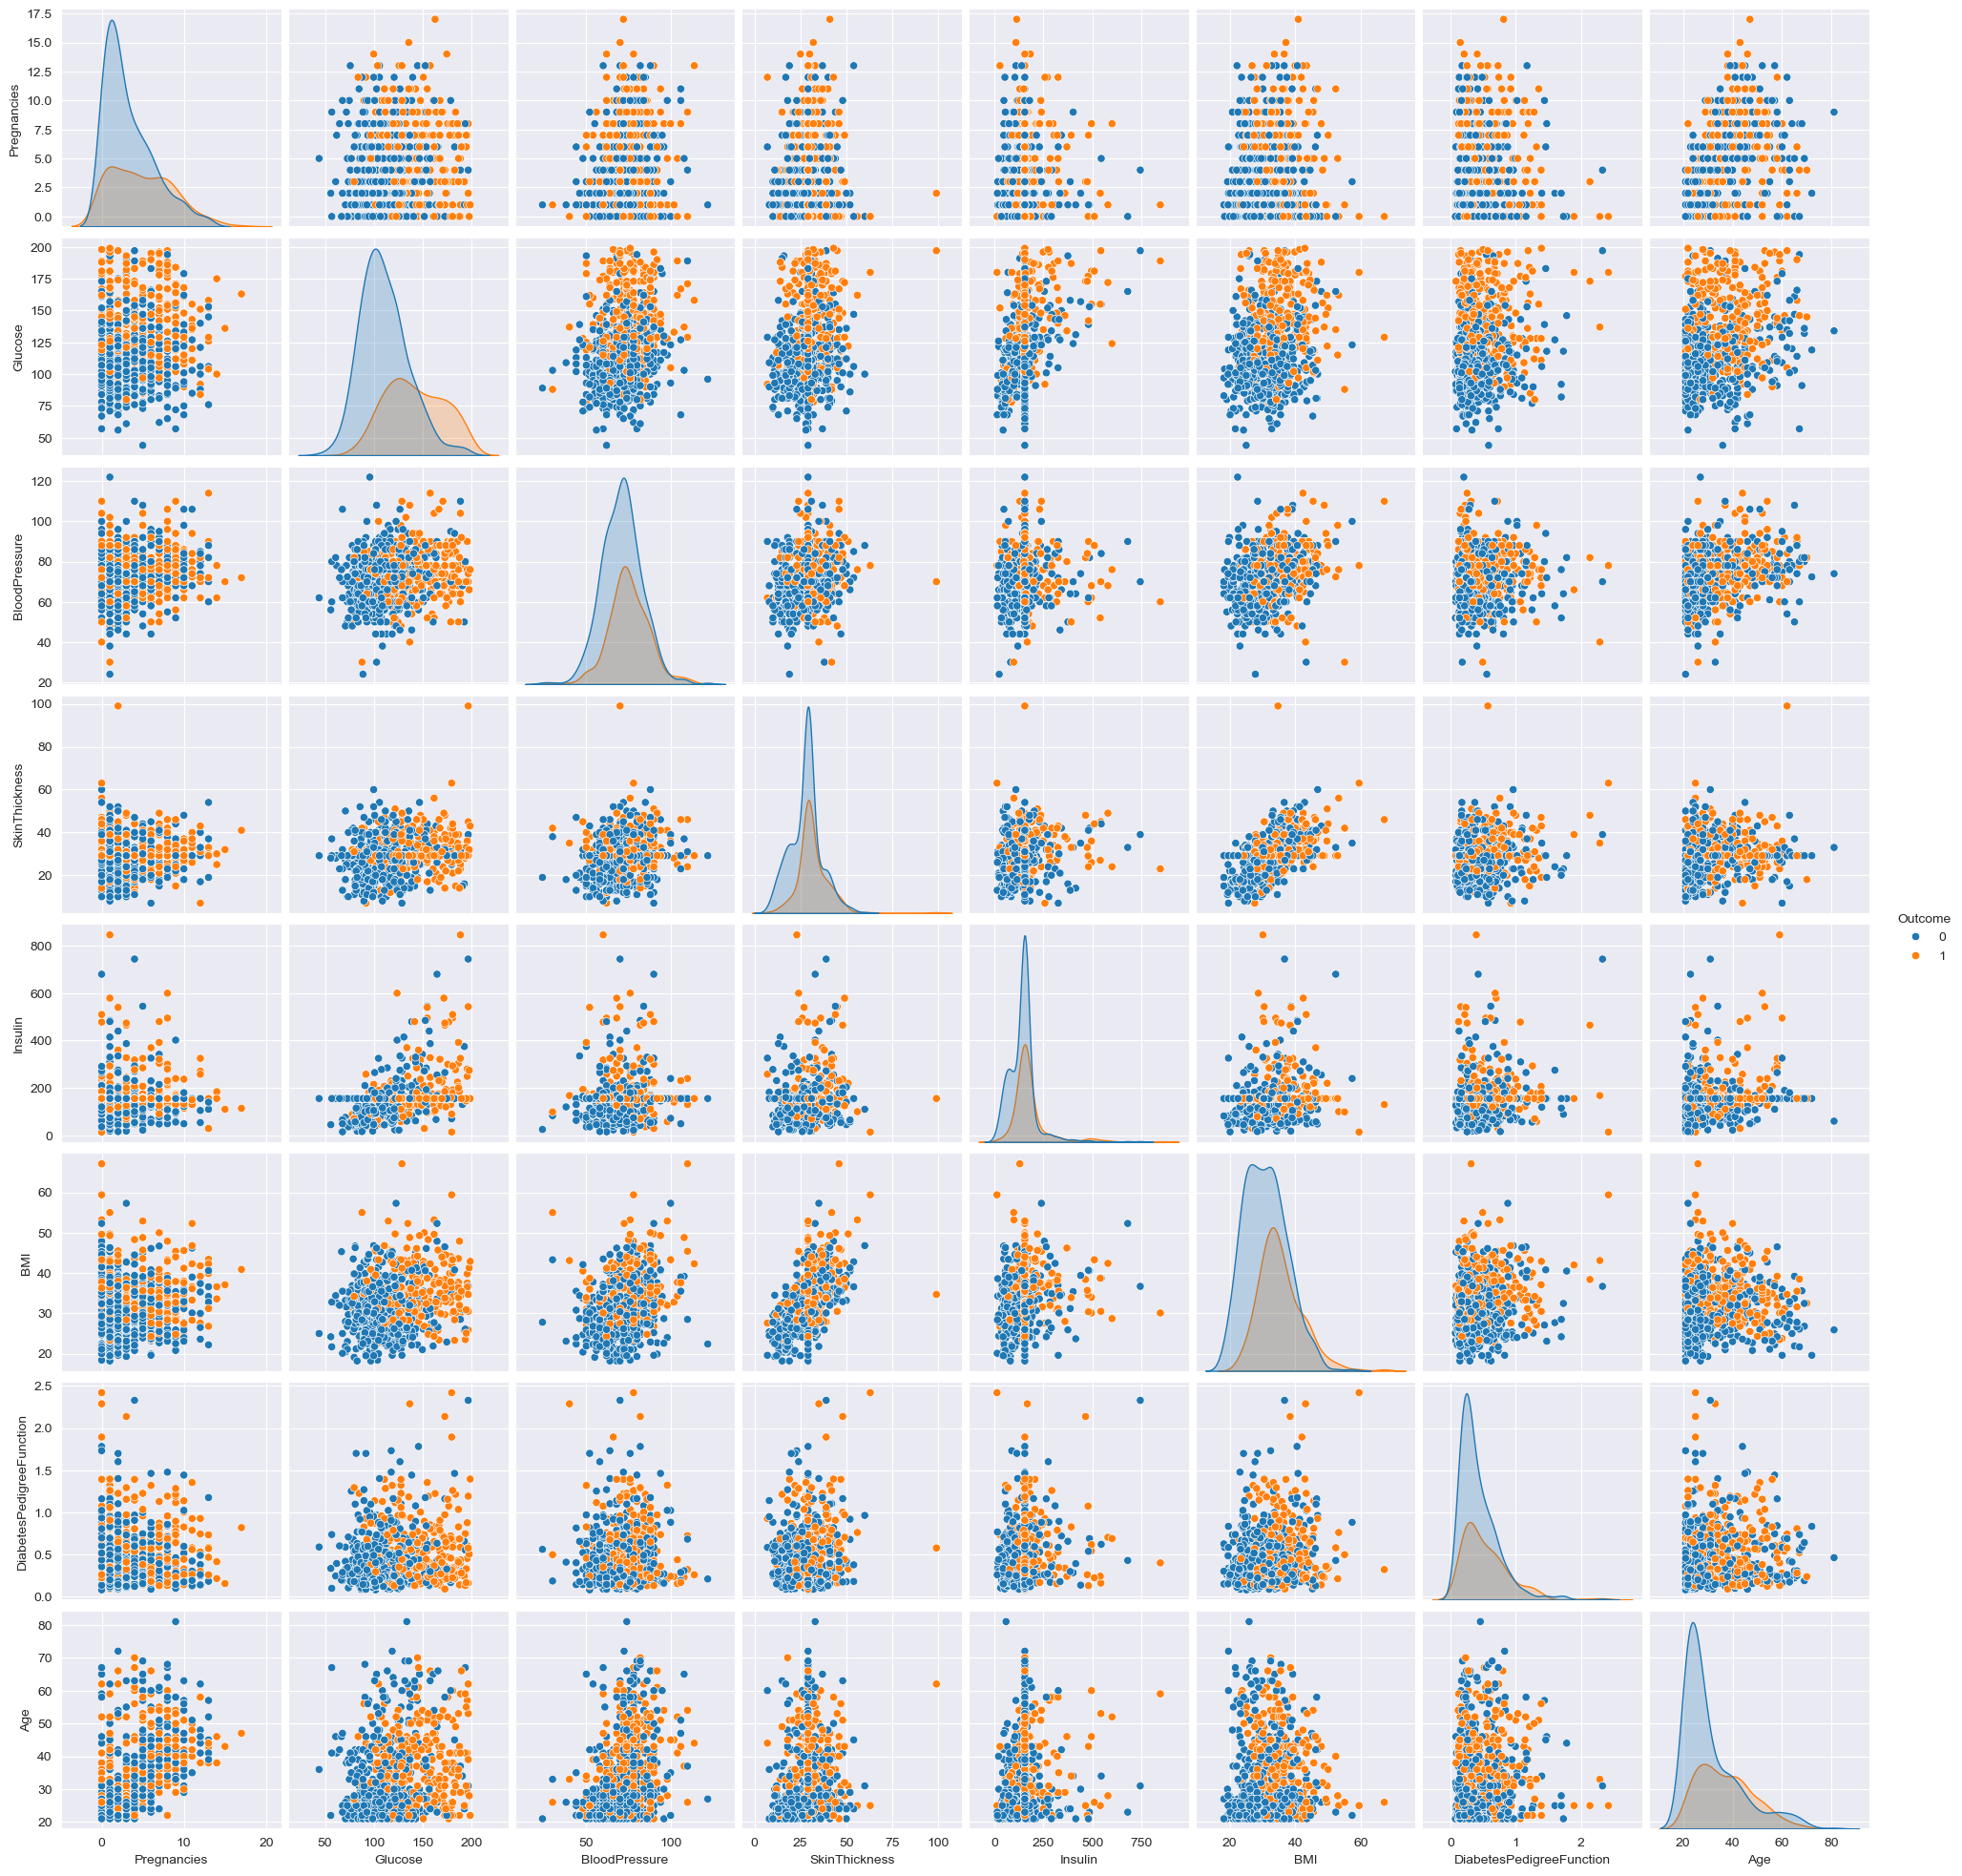

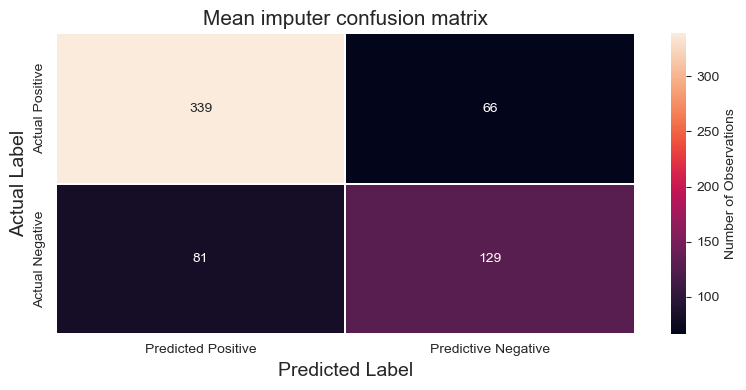

array([[339,  66],
       [ 81, 129]])

In [9]:
mean_df = df.copy()

# impute the data
mean_imputer = SimpleImputer(missing_values=0, strategy="mean")
X: DataFrame = mean_df[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]]
imputed_data = pd.DataFrame(data=np.round(a=mean_imputer.fit_transform(X=X), decimals=2), columns=X.columns)
mean_df[["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]] = imputed_data

# check for zeros
zero_mask = (mean_df == 0).sum()

sns.pairplot(data=mean_df, hue="Outcome")

X_train, X_test, Y_train, y_test = train_test_split(mean_df.iloc[:,:-1], mean_df.iloc[:,-1],train_size=0.2, random_state=42)
logistic = LogisticRegression()
fitted_logistic = logistic.fit(X=X_train, y=Y_train)
y_predict = fitted_logistic.predict(X=X_test)
accuracy_mean = accuracy_score(y_true=y_test, y_pred=y_predict)
precision_mean = precision_score(y_true=y_test, y_pred=y_predict)
recall_mean = recall_score(y_true=y_test, y_pred=y_predict)
f1_mean = f1_score(y_true=y_test, y_pred=y_predict)

print(f'Accuracy: {accuracy_mean:.4f}\nPrecision: {precision_mean:.4f}\nRecall: {recall_mean:.4f}\nF1 Score: {f1_mean:.4f}')


# Plotting the confusion matrix
cm: np.ndarray = confusion_matrix(y_true=y_test, y_pred=y_predict)
plt.figure(figsize=(8,4))
sns.heatmap(
    data=cm,
    xticklabels=["Predicted Positive", "Predictive Negative"],
    yticklabels=["Actual Positive", "Actual Negative"],
    cbar_kws={'label': 'Number of Observations'},
    linewidths=0.2, 
    fmt="d",
    annot=True,
)

plt.xlabel(xlabel="predicted label".title(), fontsize=14)
plt.ylabel(ylabel="actual label".title(), fontsize=14)
plt.title(label="Mean imputer confusion matrix", fontsize=15)

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()
cm

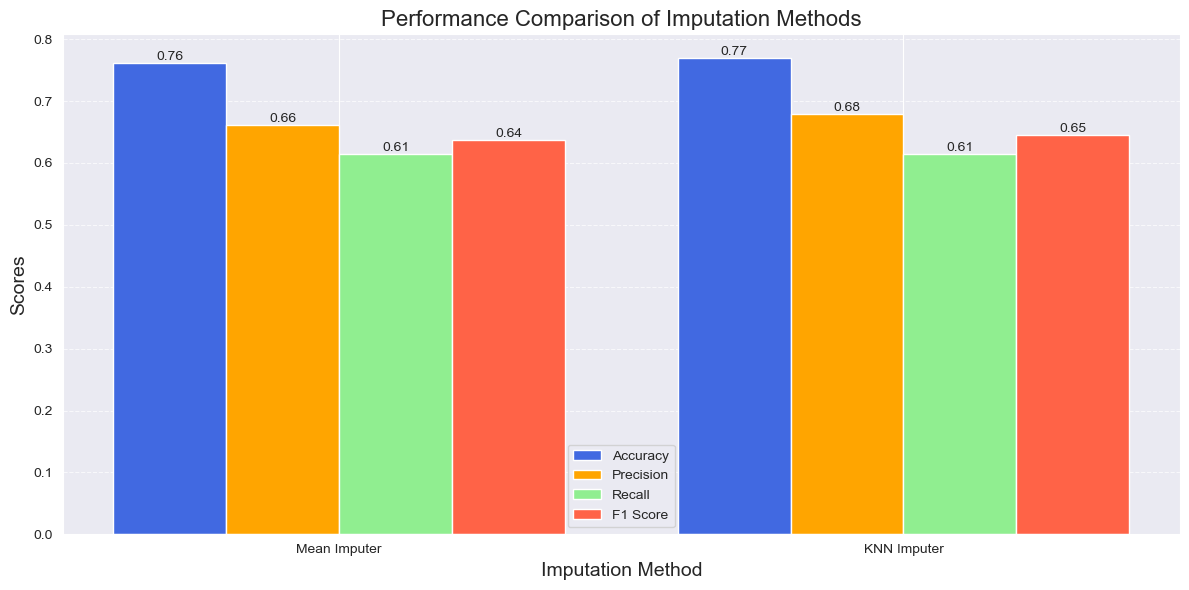

In [10]:
# Metrics for both methods
methods = ['Mean Imputer', 'KNN Imputer']
accuracy_scores = [accuracy_mean, accuracy_knn]
precision_scores = [precision_mean, precision_knn]
recall_scores = [recall_mean, recall_knn]
f1_scores = [f1_mean, f1_knn]

# Plotting
x = np.arange(len(methods))  # Use np.arange for better control over x-axis
width = 0.2  # Width of the bars

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - 1.5 * width, accuracy_scores, width, label='Accuracy', color='royalblue')
bars2 = ax.bar(x - 0.5 * width, precision_scores, width, label='Precision', color='orange')
bars3 = ax.bar(x + 0.5 * width, recall_scores, width, label='Recall', color='lightgreen')
bars4 = ax.bar(x + 1.5 * width, f1_scores, width, label='F1 Score', color='tomato')

# Add value annotations on top of each bar
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Customize the plot
ax.set_xlabel(xlabel='Imputation Method', fontsize=14)
ax.set_ylabel(ylabel='Scores', fontsize=14)
ax.set_title(label='Performance Comparison of Imputation Methods', fontsize=16)
ax.set_xticks(ticks=x)
ax.set_xticklabels(labels=methods)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


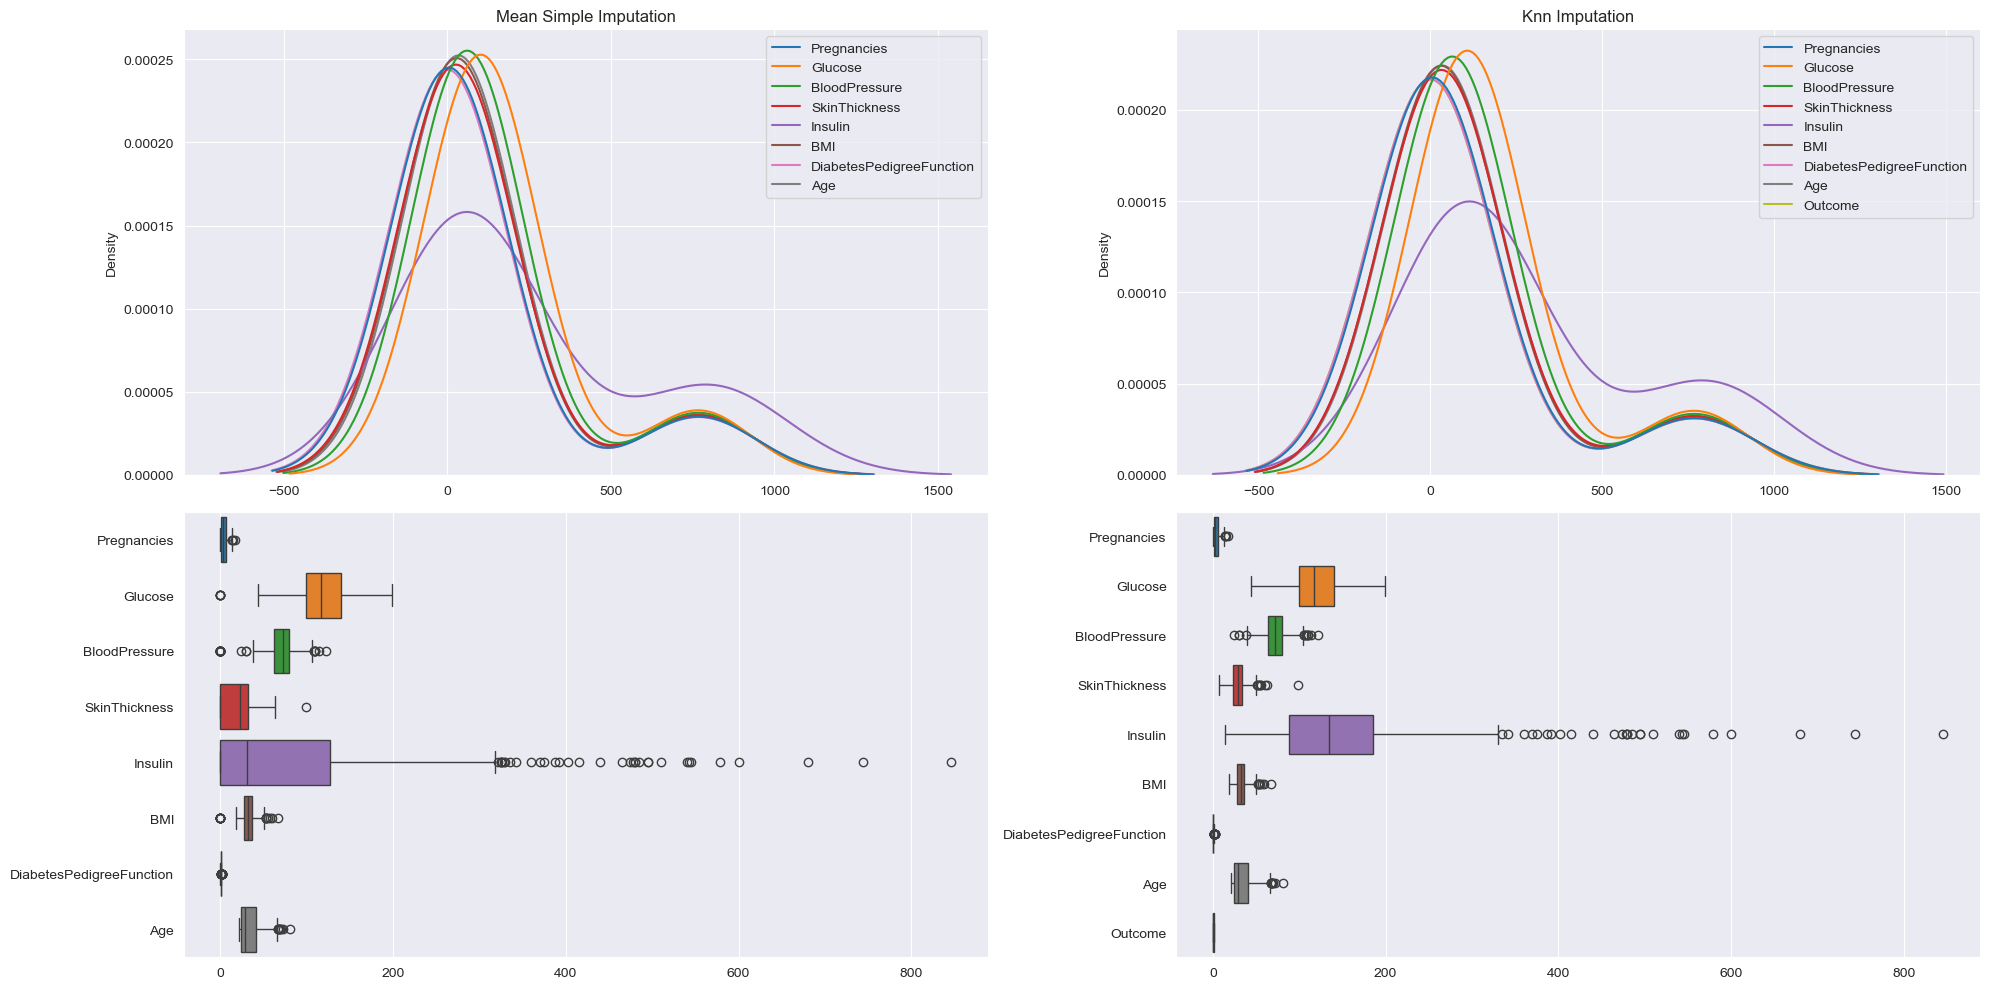

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.kdeplot(data=np.round(df[mean_df.columns[:-1]].describe(), 2), label="mean simple Imputation")
plt.title(label="mean simple Imputation".title())
plt.tight_layout()

plt.subplot(2,2,2)
sns.kdeplot(data=np.round(df_cleaning.describe(), 2), label="KNN Imputation")
plt.title(label="KNN Imputation".title())
plt.tight_layout()

plt.subplot(2,2,3)
sns.boxplot(data=df[mean_df.columns[:-1]], orient="h")
plt.tight_layout()

plt.subplot(2,2,4)
sns.boxplot(data=df_cleaning, orient="h")
plt.tight_layout()

# plt.savefig(os.path.join(file_path, "before and after imputation.png"))
plt.show()


<Axes: >

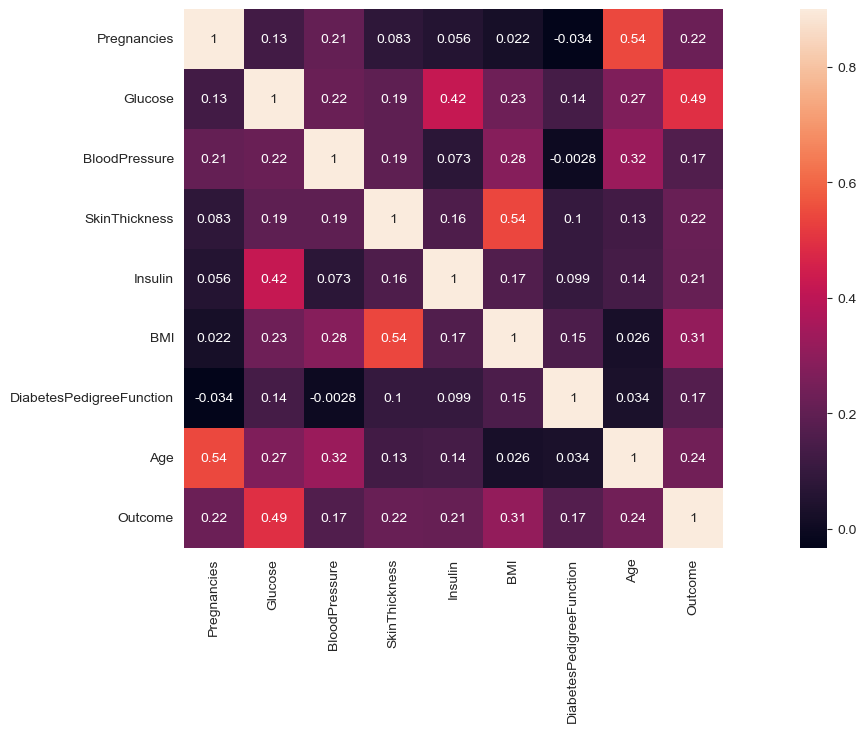

In [12]:
plt.figure(figsize=(20,7))
sns.heatmap(data=mean_df.corr(), vmax=0.9, square= True, annot=True)


## Choosing KNN Imputer  and standard scaler
**Creating pipeline**

In [13]:
data = df.copy()
X = data.iloc[:,:-1]
y =data.iloc[:, -1]

# Columns to target for KNN imputation (where you want to impute the zeros)
columns_to_impute = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Other columns (which should not be imputed but will be scaled)
remaining_columns = X.columns.difference(columns_to_impute)

# Number of neighbors for KNNImputer (k)
k: np.int64 = np.int64(np.ceil(np.sqrt(data.shape[0])))
n_neighbors: np.int64 = k if k % 2 != 0 else k - 1  # Ensure k is odd
print(type(n_neighbors), n_neighbors)

# Step 1: ColumnTransformer to apply KNNImputer to specific columns and leave others untouched
preprocessor = ColumnTransformer(
    transformers=[
        ("KNNImputer", KNNImputer(missing_values=0, n_neighbors=n_neighbors, weights="distance"), columns_to_impute),
        ("passthrough", "passthrough", remaining_columns)  # Pass through remaining columns unchanged
    ]
)

# Step 2  create pipeline then apply scaler and knn imputer
pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("StandardScaler", StandardScaler())
    ]
)
x_scaled = pipe.fit_transform(X=X)
x_scaled[:3]

<class 'numpy.int64'> 27


array([[ 0.86411981, -0.02938574,  0.65345331,  0.65694928,  0.1682198 ,
         1.4259954 ,  0.46849198,  0.63994726],
       [-1.20662242, -0.5227981 ,  0.00404501, -0.89971487, -0.84864905,
        -0.19067191, -0.36506078, -0.84488505],
       [ 2.01453216, -0.68726888,  0.12246699,  1.38375554, -1.32803008,
        -0.10558415,  0.60439732,  1.23388019]])

In [14]:
# Generate 10 random integers for random states
random_status = np.random.randint(0, 1000, size=10)
file_path = os.getcwd()

with open(os.path.join(file_path, "cross_validation.txt"), mode="w") as file:
    for random_state in random_status:
        file.write(f"random_state = {random_state}\n")

        # Split the data into train and test sets with stratification
        X_train, X_test, Y_train, y_test = train_test_split(x_scaled, y, stratify=y, train_size=0.2, random_state=random_state)

        # Set up StratifiedKFold for cross-validation
        skf = StratifiedKFold(n_splits=10)

        # Perform 10-fold cross-validation with RandomForest on original data
        rf_cv_scores = cross_val_score(RandomForestClassifier(), X_train, Y_train, cv=skf)

        # Write the array of cross-validation scores
        file.write(f"RandomForest CV scores (each fold): {np.round(rf_cv_scores * 100, 2).tolist()}\n")

        # Write the mean accuracy across the folds
        file.write(f"RandomForest mean CV score (average accuracy): {np.round(np.mean(rf_cv_scores) * 100, 2)}\n")

        # Perform 10-fold cross-validation with LogisticRegression on original data
        lr_cv_scores = cross_val_score(LogisticRegression(), X_train, Y_train, cv=skf)

        # Write the array of cross-validation scores
        file.write(f"LogisticRegression CV scores (each fold): {np.round(lr_cv_scores * 100, 2).tolist()}\n")

        # Write the mean accuracy across the folds
        file.write(f"LogisticRegression mean CV score (average accuracy): {np.round(np.mean(lr_cv_scores) * 100, 2)}\n")

        # Perform 10-fold cross-validation with RandomForest on scaled data
        rf_cv_scaled_scores = cross_val_score(RandomForestClassifier(), x_scaled, y, cv=skf)

        # Write the array of cross-validation scores for scaled data
        file.write(f"RandomForest CV scores on scaled data (each fold): {np.round(rf_cv_scaled_scores * 100, 2).tolist()}\n")

        # Write the mean accuracy for RandomForest on scaled data
        file.write(f"RandomForest mean CV score on scaled data (average accuracy): {np.round(np.mean(rf_cv_scaled_scores) * 100, 2)}\n")

        # Perform 10-fold cross-validation with LogisticRegression on scaled data
        lr_cv_scaled_scores = cross_val_score(LogisticRegression(), x_scaled, y, cv=skf)

        # Write the array of cross-validation scores for scaled data
        file.write(f"LogisticRegression CV scores on scaled data (each fold): {np.round(lr_cv_scaled_scores * 100, 2).tolist()}\n")

        # Write the mean accuracy for LogisticRegression on scaled data
        file.write(f"LogisticRegression mean CV score on scaled data (average accuracy): {np.round(np.mean(lr_cv_scaled_scores) * 100, 2)}\n")

        # Write a separator for readability
        file.write("-" * 50 + "\n\n")
print("File Written Successfully!")


File Written Successfully!


In [15]:
df_cleaning

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.00,212.56,33.6,0.627,50,1
1,1,85.0,66.0,29.00,64.59,26.6,0.351,31,0
2,8,183.0,64.0,30.56,272.30,23.3,0.672,32,1
3,1,89.0,66.0,23.00,94.00,28.1,0.167,21,0
4,0,137.0,40.0,35.00,168.00,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.00,180.00,32.9,0.171,63,0
764,2,122.0,70.0,27.00,162.70,36.8,0.340,27,0
765,5,121.0,72.0,23.00,112.00,26.2,0.245,30,0
766,1,126.0,60.0,24.78,160.63,30.1,0.349,47,1


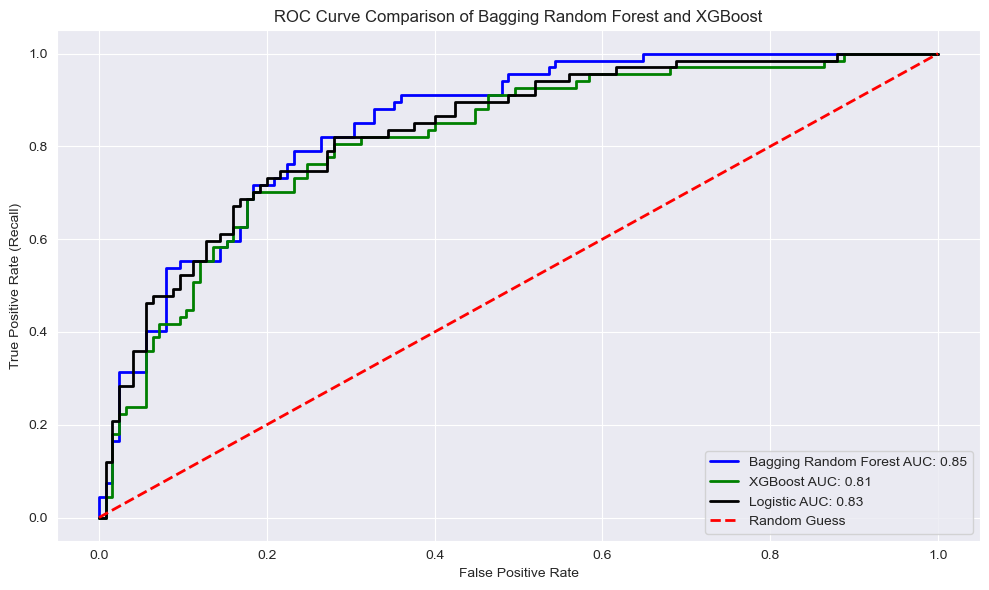

In [ ]:
scaled = StandardScaler()

X = df_cleaning.iloc[:,:-1]
y = df_cleaning.iloc[:,-1]

columns_to_scaled = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'Age']
df[columns_to_scaled] = scaled.fit_transform(X=X[columns_to_scaled])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=11)

""" --------------------------------------------------------- Bagging Random Forest ---------------------------------------------------------------"""
# bagging using random forest
bagging = BaggingClassifier(
    estimator=RandomForestClassifier(),
    n_estimators=100,
    oob_score=True,
    random_state=42,
    max_samples=0.8
)

bagging_rf = bagging.fit(X_train, y_train)

# probability of the positive 
y_probability_bagging = bagging.predict_proba(X_test)[:,1]

# compute roc and auc
fpr_bagging, tpr_bagging, threshold = roc_curve(y_true=y_test, y_score=y_probability_bagging)
auc_bagging = roc_auc_score(y_true=y_test, y_score=y_probability_bagging)

""" ------------------------------------------- XGBOOST CLASSIFIER ---------------------------------------------------------------------"""

xgboost = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgboost.fit(X_train, y_train)

# Probability of the positive class for XGBoost
y_probability_xgboost = xgboost.predict_proba(X_test)[:, 1]

# Compute ROC and AUC for XGBoost
fpr_xgboost, tpr_xgboost, _ = roc_curve(y_true=y_test, y_score=y_probability_xgboost)
auc_xgboost = roc_auc_score(y_true=y_test, y_score=y_probability_xgboost)

""" ----------------------------------------- LOGISTIC REGRESSION -----------------------------------------------------------------------"""

# Logistic Regression
logistic = LogisticRegression(random_state=11)
logistic_regression = logistic.fit(X_train, y_train)

# probability for logistic regression
y_predict_logistic = logistic_regression.predict_proba(X_test)[:,1]

fpr_logistic, tpr_logistic, _ = roc_curve(y_true=y_test, y_score=y_predict_logistic)
auc_logistic = roc_auc_score(y_true=y_test, y_score=y_predict_logistic)

""" ----------------------------------------- PLOTTING MULTIPLE ML-ALGORITHMS --------------------------------------------------------------"""

# Plotting the ROC curves for both models
plt.figure(figsize=(10, 6))

plt.plot(fpr_bagging, tpr_bagging, lw=2, color="blue", label=f"Bagging Random Forest AUC: {auc_bagging:.2f}")
plt.plot(fpr_xgboost, tpr_xgboost, lw=2, color="green", label=f"XGBoost AUC: {auc_xgboost:.2f}")
plt.plot(fpr_logistic, tpr_logistic, lw=2, color="black", label=f"Logistic AUC: {auc_logistic:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guess')

plt.xlabel(xlabel='False Positive Rate')
plt.ylabel(ylabel='True Positive Rate (Recall)')
plt.title(label='ROC Curve Comparison of Bagging Random Forest and XGBoost and logistic Regression')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()